# Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from rlcmab_sampler import sampler


# Load data

In [2]:
train_users = pd.read_csv("data/train_users.csv")
test_users  = pd.read_csv("data/test_users.csv")
news_df     = pd.read_csv("data/news_articles.csv")
# Normalize category names
news_df["category"] = news_df["category"].str.strip().str.lower()



# data cleaning

In [3]:
def fill_missing_values(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    return df

train_users = fill_missing_values(train_users)
test_users  = fill_missing_values(test_users)


## User Classification

# Contextual Bandit

In [4]:
X = train_users.drop(columns=["label", "user_id"])
y = train_users["label"]


In [5]:
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "bool"]).columns.tolist()


/tmp/ipykernel_148845/4044654874.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()


In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)


In [7]:
user_classifier = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=10,
            random_state=42
        ))
    ]
)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [9]:
user_classifier.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [10]:
y_val_pred = user_classifier.predict(X_val)

print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

cv_scores = cross_val_score(user_classifier, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")


Validation Accuracy: 0.8550

Classification Report:
              precision    recall  f1-score   support

      user_1       0.82      0.85      0.83       142
      user_2       0.94      0.85      0.89       142
      user_3       0.81      0.87      0.84       116

    accuracy                           0.85       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.85      0.86       400

Cross-validation scores: [0.8725 0.86   0.81   0.835  0.89  ]
Mean CV Accuracy: 0.8535


## Arm Mapping


In [11]:
reward_sampler = sampler(75)  # last two digits of roll number


In [12]:
user_contexts = ["User1", "User2", "User3"]
news_categories = ["entertainment", "education", "technology", "crime"]

arm_map = {}
idx = 0
for u in user_contexts:
    for c in news_categories:
        arm_map[(u, c)] = idx
        idx += 1


In [13]:
def init_bandit():
    return {
        "counts": np.zeros(4),
        "values": np.zeros(4)
    }


## Epsilon-Greedy Strategy


In [14]:
def epsilon_greedy(bandit, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 3)
    return np.argmax(bandit["values"])


In [15]:
def train_eps_greedy(epsilon, T=10000):
    bandits = {u: init_bandit() for u in user_contexts}
    rewards = []

    for _ in range(T):
        context = random.choice(user_contexts)
        bandit = bandits[context]

        arm_local = epsilon_greedy(bandit, epsilon)
        arm_global = arm_map[(context, news_categories[arm_local])]
        reward = reward_sampler.sample(arm_global)

        bandit["counts"][arm_local] += 1
        n = bandit["counts"][arm_local]
        bandit["values"][arm_local] += (reward - bandit["values"][arm_local]) / n

        rewards.append(reward)

    return bandits, np.cumsum(rewards) / np.arange(1, T + 1)


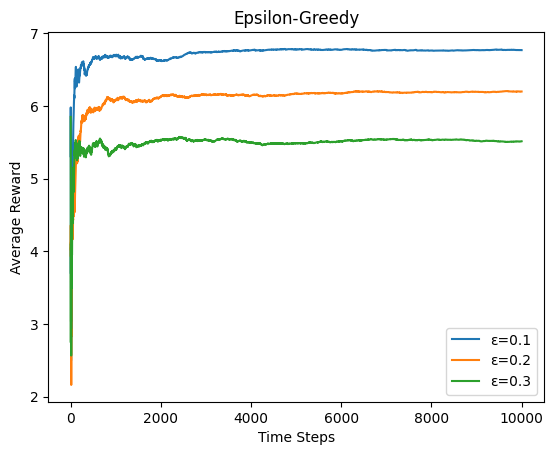

In [16]:
eps_values = [0.1, 0.2, 0.3]
eps_results = {}

for eps in eps_values:
    _, avg = train_eps_greedy(eps)
    eps_results[eps] = avg

for eps in eps_values:
    plt.plot(eps_results[eps], label=f"ε={eps}")

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("Epsilon-Greedy")
plt.legend()
plt.show()


## Upper Confidence Bound (UCB)

In [17]:
def ucb(bandit, c=2):
    total = np.sum(bandit["counts"]) + 1
    return np.argmax(
        bandit["values"] + c * np.sqrt(np.log(total) / (bandit["counts"] + 1e-6))
    )


In [18]:
def train_ucb(c, T=10000):
    bandits = {u: init_bandit() for u in user_contexts}
    rewards = []

    for _ in range(T):
        context = random.choice(user_contexts)
        bandit = bandits[context]

        arm_local = ucb(bandit, c)
        arm_global = arm_map[(context, news_categories[arm_local])]
        reward = reward_sampler.sample(arm_global)

        bandit["counts"][arm_local] += 1
        n = bandit["counts"][arm_local]
        bandit["values"][arm_local] += (reward - bandit["values"][arm_local]) / n

        rewards.append(reward)

    return bandits, np.cumsum(rewards) / np.arange(1, T + 1)


In [19]:
c_values = [0.5, 1, 2, 5]
ucb_results = {}

for c in c_values:
    _, avg_rewards = train_ucb(c)
    ucb_results[c] = avg_rewards


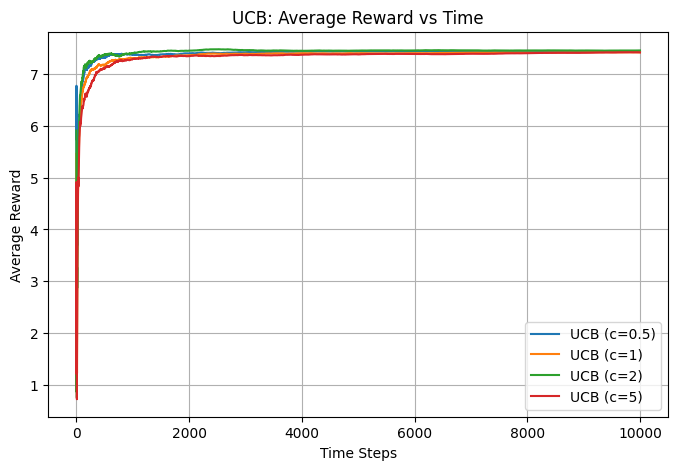

In [20]:
plt.figure(figsize=(8, 5))

for c in c_values:
    plt.plot(ucb_results[c], label=f"UCB (c={c})")

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("UCB: Average Reward vs Time")
plt.legend()
plt.grid(True)
plt.show()


## SoftMax Strategy

In [21]:
def softmax(bandit, tau=1.0):
    prefs = bandit["values"] / tau
    probs = np.exp(prefs) / np.sum(np.exp(prefs))
    return np.random.choice(len(probs), p=probs)


In [22]:
def train_softmax(T=10000):
    bandits = {u: init_bandit() for u in user_contexts}
    rewards = []

    for _ in range(T):
        context = random.choice(user_contexts)
        bandit = bandits[context]

        arm_local = softmax(bandit)
        arm_global = arm_map[(context, news_categories[arm_local])]
        reward = reward_sampler.sample(arm_global)

        bandit["counts"][arm_local] += 1
        n = bandit["counts"][arm_local]
        bandit["values"][arm_local] += (reward - bandit["values"][arm_local]) / n

        rewards.append(reward)

    return bandits, np.cumsum(rewards) / np.arange(1, T + 1)


In [23]:
tau_values = [0.1, 0.5, 1.0, 2.0]
softmax_results = {}

for tau in tau_values:
    bandits = {u: init_bandit() for u in user_contexts}
    rewards = []

    for _ in range(10000):
        context = random.choice(user_contexts)
        bandit = bandits[context]

        arm_local = softmax(bandit, tau)
        arm_global = arm_map[(context, news_categories[arm_local])]
        reward = reward_sampler.sample(arm_global)

        bandit["counts"][arm_local] += 1
        n = bandit["counts"][arm_local]
        bandit["values"][arm_local] += (reward - bandit["values"][arm_local]) / n

        rewards.append(reward)

    softmax_results[tau] = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)


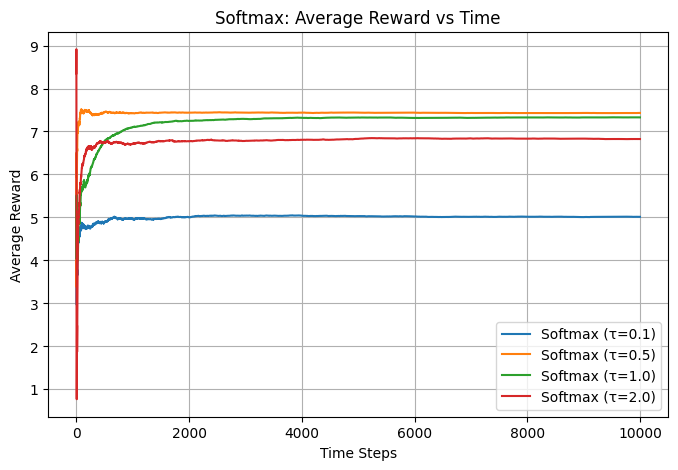

In [24]:
plt.figure(figsize=(8, 5))

for tau in tau_values:
    plt.plot(softmax_results[tau], label=f"Softmax (τ={tau})")

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("Softmax: Average Reward vs Time")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
for c in c_values:
    print(f"UCB c={c}: final avg reward = {ucb_results[c][-1]:.3f}")

for tau in tau_values:
    print(f"Softmax tau={tau}: final avg reward = {softmax_results[tau][-1]:.3f}")



UCB c=0.5: final avg reward = 7.428
UCB c=1: final avg reward = 7.411
UCB c=2: final avg reward = 7.447
UCB c=5: final avg reward = 7.409
Softmax tau=0.1: final avg reward = 5.015
Softmax tau=0.5: final avg reward = 7.432
Softmax tau=1.0: final avg reward = 7.328
Softmax tau=2.0: final avg reward = 6.824


## Results and Analysis



In [26]:
T = 10000

# Best hyperparameters (you can justify these)
best_eps = 0.1
best_c = 2

_, avg_rewards_eps = train_eps_greedy(best_eps, T)
_, avg_rewards_ucb = train_ucb(best_c, T)
_, avg_rewards_softmax = train_softmax(T)


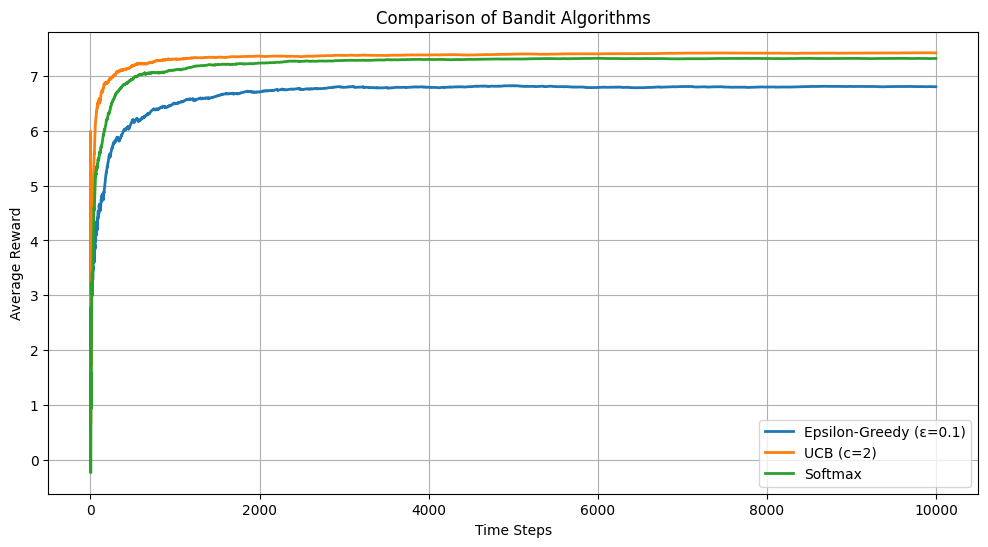

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(avg_rewards_eps, label=f"Epsilon-Greedy (ε={best_eps})", linewidth=2)
plt.plot(avg_rewards_ucb, label=f"UCB (c={best_c})", linewidth=2)
plt.plot(avg_rewards_softmax, label="Softmax", linewidth=2)

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("Comparison of Bandit Algorithms")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print("\nFinal Average Rewards:")
print("=" * 40)
print(f"Epsilon-Greedy (ε={best_eps}): {avg_rewards_eps[-1]:.4f}")
print(f"UCB (c={best_c}): {avg_rewards_ucb[-1]:.4f}")
print(f"Softmax: {avg_rewards_softmax[-1]:.4f}")



Final Average Rewards:
Epsilon-Greedy (ε=0.1): 6.7981
UCB (c=2): 7.4143
Softmax: 7.3127


### Hencee UCB is giving the best reward

## Recommendation Engine

In [29]:
def recommend_article(user_row, policy_bandits):
    user_df = user_row.drop("user_id").to_frame().T
    predicted_label = user_classifier.predict(user_df)[0]
    user_context = label_to_context[predicted_label]

    bandit = policy_bandits[user_context]
    best_arm = np.argmax(bandit["values"])
    category = news_categories[best_arm]
    candidates = news_df[news_df["category"] == category]
    if len(candidates) == 0:
        return news_df.sample(1)

    return candidates.sample(1)


In [30]:
label_to_context = {
    "user_1": "User1",
    "user_2": "User2",
    "user_3": "User3"
}

policy_bandits, _ = train_eps_greedy(0.1)

sample_user = test_users.iloc[0]
recommend_article(sample_user, policy_bandits)


,link,headline,category,short_description,authors,date
54942,https://www.huffingtonpost.com/entry/candace-c...,Candace Cameron Bure's Teenage Daughter Gets A...,entertainment,"She's got it, dude.",Cole Delbyck,2016-10-04


In [31]:
all_recommendations = []

for _, user_row in test_users.iterrows():
    user_df = user_row.drop("user_id").to_frame().T
    predicted_label = user_classifier.predict(user_df)[0]
    user_context = label_to_context[predicted_label]
    bandit = policy_bandits[user_context]
    best_arm = np.argmax(bandit["values"])
    recommended_category = news_categories[best_arm]

    all_recommendations.append({
        "user_id": user_row["user_id"],
        "user_category": user_context,
        "recommended_category": recommended_category
    })




In [32]:
recommended_categories = [
    rec["recommended_category"] for rec in all_recommendations
]

print("\nRecommendation Distribution Across Categories:")
print("=" * 80)

for category in news_categories:
    count = recommended_categories.count(category)
    percentage = (count / len(recommended_categories)) * 100
    print(f"{category:15s}: {count:4d} ({percentage:5.2f}%)")



Recommendation Distribution Across Categories:
entertainment  :  638 (31.90%)
education      :  714 (35.70%)
technology     :    0 ( 0.00%)
crime          :  648 (32.40%)


In [33]:
predicted_users = [
    rec["user_category"] for rec in all_recommendations
]

print("\n\nPredicted User Distribution:")
print("=" * 80)

for user_cat in user_contexts:
    count = predicted_users.count(user_cat)
    percentage = (count / len(predicted_users)) * 100
    print(f"{user_cat:15s}: {count:4d} ({percentage:5.2f}%)")




Predicted User Distribution:
User1          :  648 (32.40%)
User2          :  714 (35.70%)
User3          :  638 (31.90%)


In [34]:
print("\nSample recommendations:")
for rec in all_recommendations[:5]:
    print(rec)



Sample recommendations:
{'user_id': 'U4058', 'user_category': 'User3', 'recommended_category': 'entertainment'}
{'user_id': 'U1118', 'user_category': 'User1', 'recommended_category': 'crime'}
{'user_id': 'U6555', 'user_category': 'User1', 'recommended_category': 'crime'}
{'user_id': 'U9170', 'user_category': 'User1', 'recommended_category': 'crime'}
{'user_id': 'U3348', 'user_category': 'User1', 'recommended_category': 'crime'}


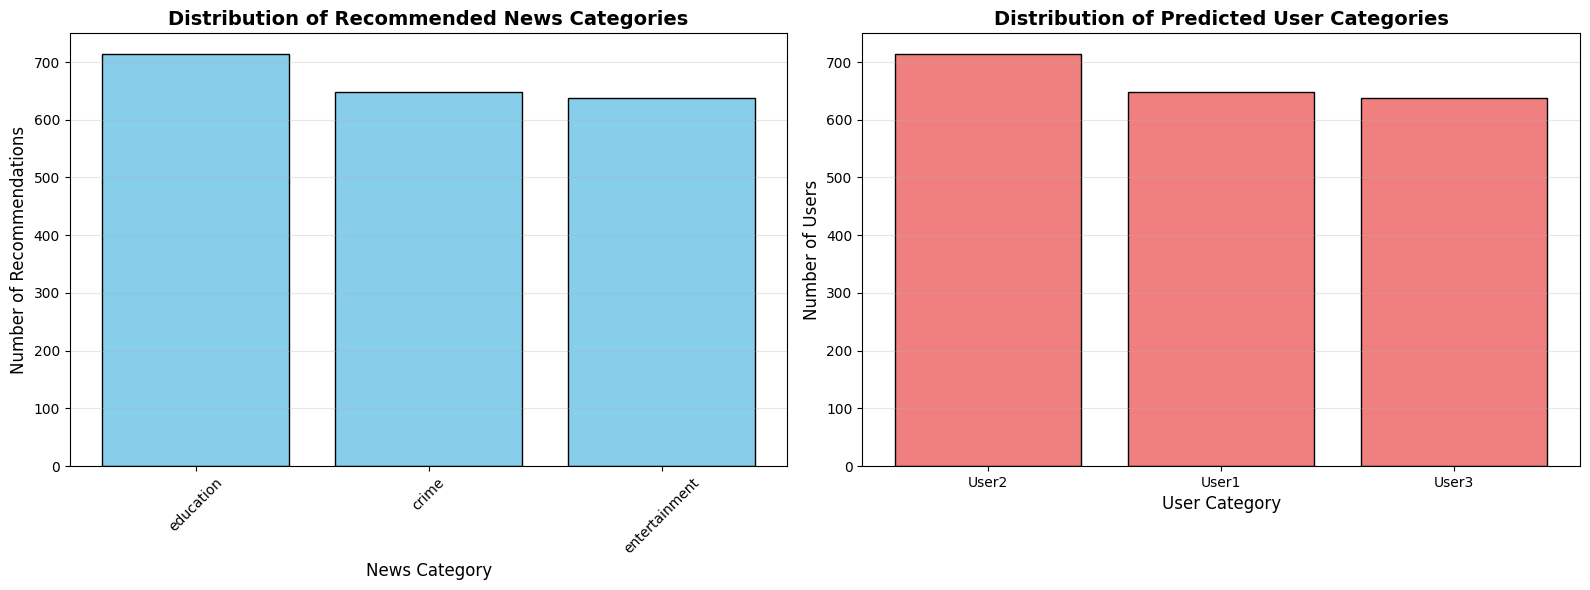

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

category_counts = pd.Series(recommended_categories).value_counts()

axes[0].bar(
    category_counts.index,
    category_counts.values,
    color="skyblue",
    edgecolor="black"
)

axes[0].set_xlabel("News Category", fontsize=12)
axes[0].set_ylabel("Number of Recommendations", fontsize=12)
axes[0].set_title(
    "Distribution of Recommended News Categories",
    fontsize=14,
    fontweight="bold"
)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", alpha=0.3)

user_counts = pd.Series(predicted_users).value_counts()

axes[1].bar(
    user_counts.index,
    user_counts.values,
    color="lightcoral",
    edgecolor="black"
)

axes[1].set_xlabel("User Category", fontsize=12)
axes[1].set_ylabel("Number of Users", fontsize=12)
axes[1].set_title(
    "Distribution of Predicted User Categories",
    fontsize=14,
    fontweight="bold"
)
axes[1].grid(axis="y", alpha=0.3)

# Final layout
plt.tight_layout()
plt.show()


#### 1. Algorithm Performance Comparison

**Epsilon-Greedy:**
- Simple and effective exploration-exploitation strategy
- Performance heavily depends on epsilon value
- Lower epsilon (more exploitation) may converge faster but might miss optimal arms
- Higher epsilon (more exploration) explores more but may sacrifice short-term rewards

**Upper Confidence Bound (UCB):**
- Systematic exploration based on uncertainty
- Balances exploration and exploitation more intelligently than epsilon-greedy
- The exploration parameter c controls the confidence interval width
- Generally provides more stable performance across different scenarios

**SoftMax:**
- Probabilistic action selection based on estimated values
- Temperature parameter τ controls exploration intensity
- Provides smooth transition between exploration and exploitation
- With τ=1, provides balanced exploration-exploitation

#### 2. Hyperparameter Sensitivity

**Epsilon (ε) in Epsilon-Greedy:**
- Lower values (0.1): More exploitation, faster convergence but may get stuck in suboptimal arms
- Medium values (0.2): Good balance for most scenarios
- Higher values (0.3): More exploration, slower convergence but better long-term optimization

**Exploration Parameter (c) in UCB:**
- Lower values (0.5): More exploitation-focused
- Medium values (1.0): Theoretical optimal for many problems
- Higher values (2.0): More aggressive exploration

#### 3. Context-Specific Performance

- Different user contexts (User1, User2, User3) may have different reward distributions
- The bandit learns context-specific preferences over time
- Some news categories may be universally preferred while others are context-dependent


This contextual bandit approach:
- Maps users to appropriate contexts
- Learns context-specific preferences
- Balances exploration and exploitation
- Provides personalized recommendations




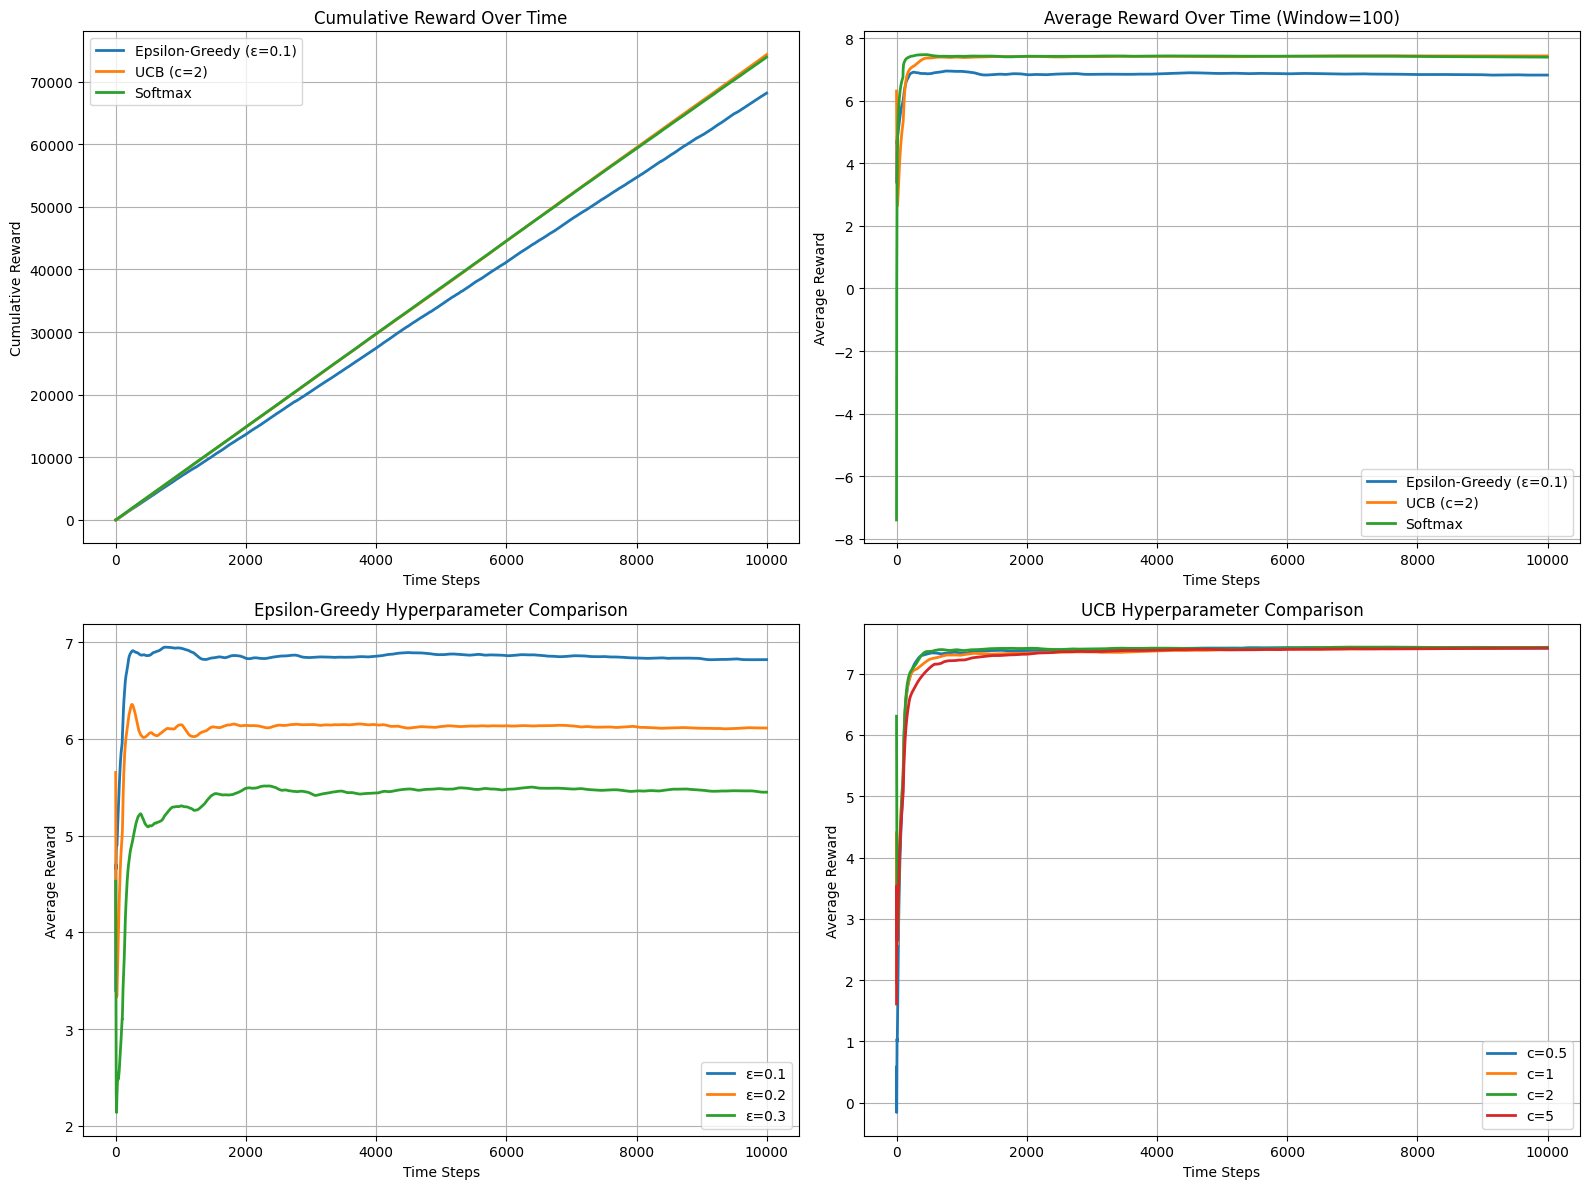

In [36]:
T = 10000
epsilon_values = [0.1, 0.2, 0.3]
epsilon_results = {}

for eps in epsilon_values:
    _, avg_rewards = train_eps_greedy(eps, T)
    epsilon_results[eps] = avg_rewards
best_eps = max(epsilon_results, key=lambda e: epsilon_results[e][-1])

c_values = [0.5, 1, 2, 5]
ucb_results = {}

for c in c_values:
    _, avg_rewards = train_ucb(c, T)
    ucb_results[c] = avg_rewards
best_c = max(ucb_results, key=lambda c: ucb_results[c][-1])
_, softmax_rewards = train_softmax(T)

def cumulative_from_average(avg_rewards):
    return avg_rewards * np.arange(1, len(avg_rewards) + 1)

def moving_average(arr, window=100):
    return np.array([
        np.mean(arr[max(0, i - window + 1):i + 1])
        for i in range(len(arr))
    ])
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(
    cumulative_from_average(epsilon_results[best_eps]),
    label=f"Epsilon-Greedy (ε={best_eps})",
    linewidth=2
)
axes[0, 0].plot(
    cumulative_from_average(ucb_results[best_c]),
    label=f"UCB (c={best_c})",
    linewidth=2
)
axes[0, 0].plot(
    cumulative_from_average(softmax_rewards),
    label="Softmax",
    linewidth=2
)

axes[0, 0].set_title("Cumulative Reward Over Time")
axes[0, 0].set_xlabel("Time Steps")
axes[0, 0].set_ylabel("Cumulative Reward")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(
    moving_average(epsilon_results[best_eps]),
    label=f"Epsilon-Greedy (ε={best_eps})",
    linewidth=2
)
axes[0, 1].plot(
    moving_average(ucb_results[best_c]),
    label=f"UCB (c={best_c})",
    linewidth=2
)
axes[0, 1].plot(
    moving_average(softmax_rewards),
    label="Softmax",
    linewidth=2
)

axes[0, 1].set_title("Average Reward Over Time (Window=100)")
axes[0, 1].set_xlabel("Time Steps")
axes[0, 1].set_ylabel("Average Reward")
axes[0, 1].legend()
axes[0, 1].grid(True)

for eps in epsilon_values:
    axes[1, 0].plot(
        moving_average(epsilon_results[eps]),
        label=f"ε={eps}",
        linewidth=2
    )

axes[1, 0].set_title("Epsilon-Greedy Hyperparameter Comparison")
axes[1, 0].set_xlabel("Time Steps")
axes[1, 0].set_ylabel("Average Reward")
axes[1, 0].legend()
axes[1, 0].grid(True)

for c in c_values:
    axes[1, 1].plot(
        moving_average(ucb_results[c]),
        label=f"c={c}",
        linewidth=2
    )

axes[1, 1].set_title("UCB Hyperparameter Comparison")
axes[1, 1].set_xlabel("Time Steps")
axes[1, 1].set_ylabel("Average Reward")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
